In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

Import data

In [2]:
csv_file_path_movies = r'C:\Users\gusta\Documents\Data Science Bootcamp\Data Science\Chapter 8\Data\ml-latest-small\movies.csv'
csv_file_path_ratings = r'C:\Users\gusta\Documents\Data Science Bootcamp\Data Science\Chapter 8\Data\ml-latest-small\ratings.csv'
csv_file_path_tags = r'C:\Users\gusta\Documents\Data Science Bootcamp\Data Science\Chapter 8\Data\ml-latest-small\tags.csv'
csv_file_path_links = r'C:\Users\gusta\Documents\Data Science Bootcamp\Data Science\Chapter 8\Data\ml-latest-small\links.csv'

movies_df = pd.read_csv(csv_file_path_movies)
ratings_df = pd.read_csv(csv_file_path_ratings)
tags_df = pd.read_csv(csv_file_path_tags)
links_df = pd.read_csv(csv_file_path_links)

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# Popularity recommender

In [7]:
rating_count_df = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
rating_count_df.nlargest(5, ['mean', 'count'])

,movieId,mean,count
48,53,5.0,2
87,99,5.0,2
869,1151,5.0,2
2593,3473,5.0,2
4384,6442,5.0,2


In [8]:
rating_count_df.sort_values(by=['count', 'mean'], ascending=False).head(5)

,movieId,mean,count
314,356,4.164134,329
277,318,4.429022,317
257,296,4.197068,307
510,593,4.161290,279
1938,2571,4.192446,278


In [10]:
def popularity_recommender():
    
    n = input('Enter number of movies do you want to display: ')

    movies_info_columns = ['movieId', 'title', 'genres']

    filtered_movies = rating_count_df[(rating_count_df['mean'] > 4) & (rating_count_df['count'] > 100)]

    filtered_movies_sorted = filtered_movies.sort_values(by='mean', ascending=False)

    filtered_moviesId = filtered_movies_sorted['movieId'].values

    filtered_moviesId_mask = ratings_df['movieId'].isin(filtered_moviesId)

    filtered_movies_info = ratings_df.loc[filtered_moviesId_mask, 'movieId'].drop_duplicates()

    mean_ratings = ratings_df.groupby('movieId')['rating'].mean().reset_index()
    filtered_movies_info = pd.merge(filtered_movies_info, movies_df, on='movieId', how='left')
    filtered_movies_info = pd.merge(filtered_movies_info, mean_ratings, on='movieId', how='left')
    filtered_movies_info.rename(columns={'rating': 'mean_rating'}, inplace=True)

    filtered_movies_info = filtered_movies_info.set_index('movieId').loc[filtered_moviesId].reset_index()
    
    return(filtered_movies_info.head(int(n)))

popularity_recommender()

,movieId,title,genres,mean_rating
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022
1,858,"Godfather, The (1972)",Crime|Drama,4.289062
2,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936
3,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.259690
4,48516,"Departed, The (2006)",Crime|Drama|Thriller,4.252336
5,1213,Goodfellas (1990),Crime|Drama,4.250000
6,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.238255
7,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.237745
8,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.232394
9,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076


In [13]:
filtered_movies_for_image = popularity_recommender()

In [14]:
filtered_movies_info_imdb = pd.merge(filtered_movies_for_image, links_df, on='movieId', how='left')

In [16]:
filtered_movies_info_imdb = filtered_movies_info_imdb['imdbId']
filtered_movies_info_imdb 

0    111161
1     68646
2    137523
3     71562
4    407887
5     99685
6    468569
7    114814
8     93779
9     76759
Name: imdbId, dtype: int64

# Item-based recommender

Cosine similarity correlation

In [83]:
def Top_N_recomendations():

  # name = input('Enter the name of the movie: ')
  # result = movies_df[movies_df['title'] == name]['movieId']

  # if not result.empty:
  #   movie_id = result.iloc[0]
  # else:
  #   print(f"No movie found with the title '{name}'.")

  # n = input('Enter the amount of similar movies you want to find: ')
  movie_titles = movies_df['title'].tolist()

  name = input('Enter the name of the movie: ')

  # Search for a movie title that contains the input name
  matching_titles = [title for title in movie_titles if name.lower() in title.lower()]

  if matching_titles:
    # Automatically choose the first matching title
    selected_movie_title = matching_titles[0]
    result = movies_df[movies_df['title'] == selected_movie_title]['movieId']

    if not result.empty:
        movie_id = result.iloc[0]
        
    else:
        print(f"No movie found with the title '{selected_movie_title}'.")
  else:
    print(f"No movie found containing '{name}'.")

  n = input('Enter the amount of similar movies you want to find: ')
  user_movie_matrix = pd.pivot_table(data=ratings_df,
                                  values='rating',
                                  index='userId',
                                  columns='movieId',
                                  fill_value=0)

  movies_cosines_matrix = pd.DataFrame(cosine_similarity(user_movie_matrix.T),
                                    columns=user_movie_matrix.columns,
                                    index=user_movie_matrix.columns)

 

  

  movies_cosines_df = pd.DataFrame(movies_cosines_matrix[movie_id])


  movies_cosines_df = movies_cosines_df.rename(columns={movie_id: name})

  movies_cosines_df = movies_cosines_df[movies_cosines_df.index != movie_id]


  movies_cosines_df = movies_cosines_df.sort_values(by=name, ascending=False)


  no_of_users_rated_both_movies = [sum((user_movie_matrix[movie_id] > 0) & (user_movie_matrix[i] > 0)) for i in movies_cosines_df.index]


  movies_cosines_df['users_who_rated_both_movies'] = no_of_users_rated_both_movies


  movies_cosines_df = movies_cosines_df[movies_cosines_df["users_who_rated_both_movies"] > 10]

  movies_cosines_df = movies_cosines_df.rename(columns={name: f'{name}_cosine'})

  movies_info_columns = ['movieId', 'title', 'genres']

  top_n_recomendations = (movies_cosines_df
                              .head(int(n))
                              .reset_index()
                              .merge(movies_df.drop_duplicates(subset='movieId'),
                                     on='movieId',
                                     how='left')
                              [movies_info_columns + [f'{name}_cosine',	'users_who_rated_both_movies']] 
                              )


  return(top_n_recomendations)

Top_N_recomendations()

Found movie: 'Toy Story (1995)' with Movie ID: 1


,movieId,title,genres,toy story_cosine,users_who_rated_both_movies
0,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.572601,81
1,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.565637,132
2,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.564262,122
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.557388,134
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.547096,154
5,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.541145,107
6,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0.541089,116
7,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,0.538913,106
8,1265,Groundhog Day (1993),Comedy|Fantasy|Romance,0.534169,97
9,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,0.530381,106


# User-based recommender

## Testing KNN

In [33]:
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [11]:
data = ratings_df[['userId', 'movieId', 'rating']]

In [12]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(data, reader)

In [13]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=142)

In [14]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

knn = KNNBasic(sim_options=sim_options)

In [15]:
knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [16]:
predictions = knn.test(testset)

In [17]:
predictions[:5]

[Prediction(uid=380, iid=2085, r_ui=3.0, est=3.5191062895722083, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=367, iid=513, r_ui=4.0, est=2.9999999999999996, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=570, iid=349, r_ui=4.0, est=3.7123899526005637, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288, iid=2018, r_ui=3.0, est=3.391371971142089, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid=446, iid=266, r_ui=2.0, est=3.4014122408648797, details={'actual_k': 40, 'was_impossible': False})]

In [18]:
predictions_df = pd.DataFrame(predictions, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])
predictions_df.head()

,raw_user_id,raw_item_id,actual_user_rating,estimated_user_rating,details
0,380,2085,3.0,3.519106,"{'actual_k': 30, 'was_impossible': False}"
1,367,513,4.0,3.000000,"{'actual_k': 2, 'was_impossible': False}"
2,570,349,4.0,3.712390,"{'actual_k': 40, 'was_impossible': False}"
3,288,2018,3.0,3.391372,"{'actual_k': 29, 'was_impossible': False}"
4,446,266,2.0,3.401412,"{'actual_k': 40, 'was_impossible': False}"


In [19]:
accuracy.mae(predictions)

MAE:  0.7466


0.7465676186021254

In [20]:
accuracy.rmse(predictions)

RMSE: 0.9706


0.9706404973871133

In [21]:
accuracy.fcp(predictions)

FCP:  0.6685


0.6684847446082518

In [22]:
predictions_df["difference"] = predictions_df["actual_user_rating"] - predictions_df["estimated_user_rating"]

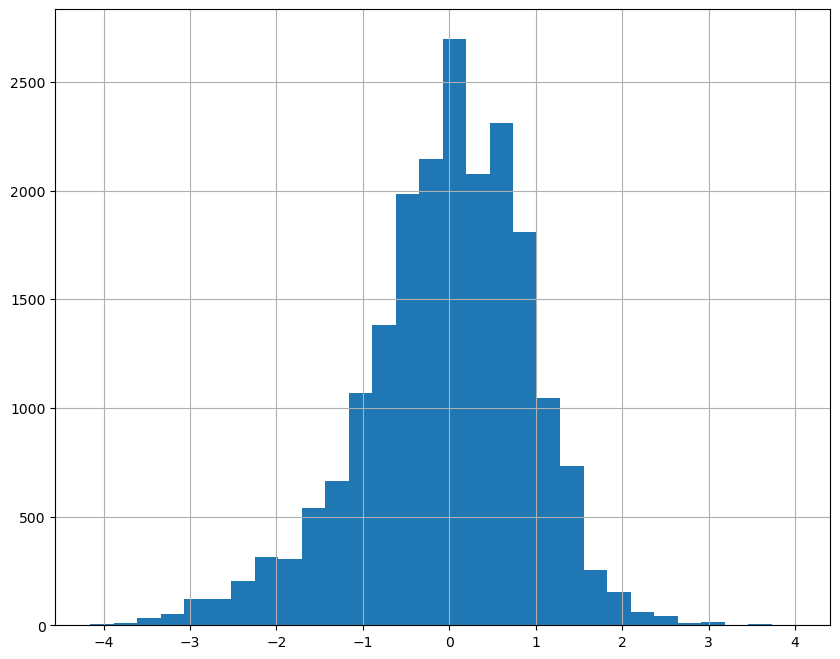

In [23]:
predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

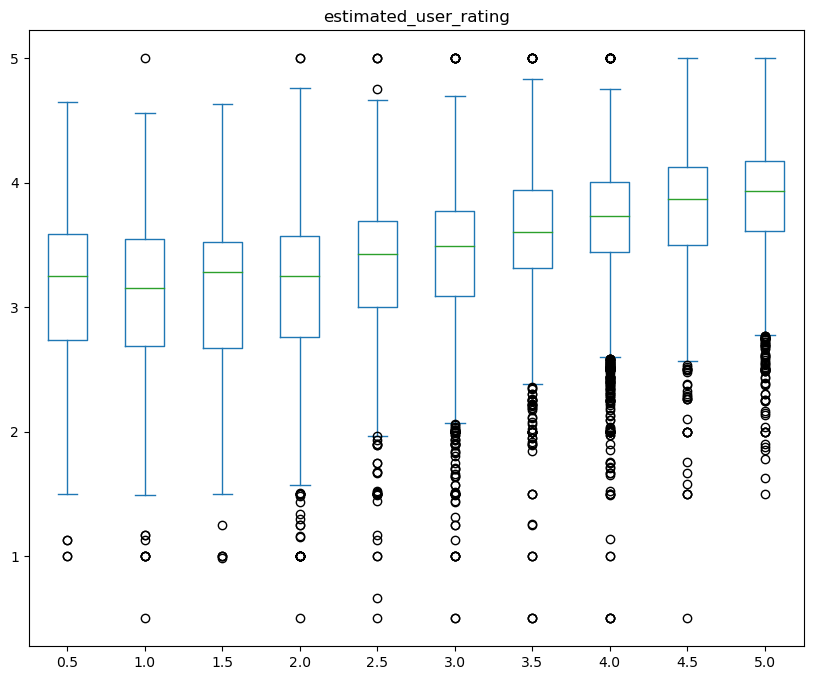

In [26]:
predictions_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

## Testing SVD

In [56]:
from surprise import SVD


In [57]:
svd = SVD()
svd.fit(trainset)

In [58]:
predictions_svd = svd.test(testset)

In [26]:
predictions_df = pd.DataFrame(predictions_svd, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])
predictions_df.head()

,raw_user_id,raw_item_id,actual_user_rating,estimated_user_rating,details
0,380,2085,3.0,3.563751,{'was_impossible': False}
1,367,513,4.0,3.856962,{'was_impossible': False}
2,570,349,4.0,3.213756,{'was_impossible': False}
3,288,2018,3.0,3.045479,{'was_impossible': False}
4,446,266,2.0,3.322756,{'was_impossible': False}


In [27]:
accuracy.mae(predictions_svd)

MAE:  0.6694


0.6693577021424181

In [28]:
accuracy.rmse(predictions_svd)

RMSE: 0.8716


0.8716326361759701

In [31]:
accuracy.fcp(predictions_svd)

FCP:  0.6583


0.6582960456903406

## Testing several models

In [70]:
from surprise import NMF
from surprise.model_selection import cross_validate
from collections import defaultdict
import numpy as np

In [65]:
# Define models and their parameter grids
models = [
    ('SVD', SVD, {'n_factors': [5, 10, 15], 'n_epochs': [20, 30]}),
    ('NMF', NMF, {'n_factors': [5, 10, 15], 'n_epochs': [20, 30]}),
    ('KNNBasic', KNNBasic, {'k': [20, 30, 40]})
]


In [74]:


# Define models and their parameter grids
models = [
    ('SVD', SVD, {'n_factors': [5, 10, 15], 'n_epochs': [20, 30]}),
    ('NMF', NMF, {'n_factors': [5, 10, 15], 'n_epochs': [20, 30]}),
    ('KNNBasic', KNNBasic, {'k': [20, 30, 40]})
]

results = []
for model_name, model_class, param_grid in models:
    best_fcp = 0
    best_params = None

    if model_name in ['SVD', 'NMF']:
        for n_factors in param_grid['n_factors']:
            for n_epochs in param_grid['n_epochs']:
                # Create the model instance with specified hyperparameters
                model = model_class(n_factors=n_factors, n_epochs=n_epochs)

                # Train the model on the training data
                model.fit(trainset)

                # Compute FCP using accuracy.fcp
                fcp = accuracy.fcp(model.test(testset))

                # Update the best FCP and best_params if necessary
                if fcp > best_fcp:
                    best_fcp = fcp
                    best_params = {'n_factors': n_factors, 'n_epochs': n_epochs}
    elif model_name == 'KNNBasic':
        for k in param_grid['k']:
            # Create the model instance with specified hyperparameters
            model = model_class(k=k)

            # Train the model on the training data
            model.fit(trainset)

            # Compute FCP using accuracy.fcp
            fcp = accuracy.fcp(model.test(testset))

            # Update the best FCP and best_params if necessary
            if fcp > best_fcp:
                best_fcp = fcp
                best_params = {'k': k}

    # Store the results
    results.append((model_name, best_fcp, best_params))

# Print the results
for model_name, best_fcp, best_params in results:
    print(f"Model: {model_name}, Best FCP Accuracy: {best_fcp}, Best Params: {best_params}")


FCP:  0.6698
FCP:  0.6732
FCP:  0.6696
FCP:  0.6693
FCP:  0.6652
FCP:  0.6671
FCP:  0.6181
FCP:  0.6257
FCP:  0.6365
FCP:  0.6344
FCP:  0.6502
FCP:  0.6424
Computing the msd similarity matrix...
Done computing similarity matrix.
FCP:  0.6732
Computing the msd similarity matrix...
Done computing similarity matrix.
FCP:  0.6739
Computing the msd similarity matrix...
Done computing similarity matrix.
FCP:  0.6727
Model: SVD, Best FCP Accuracy: 0.6731801567677105, Best Params: {'n_factors': 5, 'n_epochs': 30}
Model: NMF, Best FCP Accuracy: 0.6502056207297665, Best Params: {'n_factors': 15, 'n_epochs': 20}
Model: KNNBasic, Best FCP Accuracy: 0.6738907242550266, Best Params: {'k': 30}


## Making a Model

In [36]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

full_train = data.build_full_trainset()
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [38]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [114]:
import pickle

pickle.dump(algo, open(file=r'C:\Users\gusta\Documents\Data Science Bootcamp\Data Science\Chapter 8\trained_pipe_knn.sav', mode='wb'))

In [39]:
def get_top_n(predictions, user_id, n=10):

  user_recommendations = []

  # Iterate through each prediction tuple
  for uid, iid, true_r, est, _ in predictions:
    # Check if the user ID matches the target user
    if user_id == uid:
      # Append item_id and estimated_rating to the user_recommendations list
      user_recommendations.append((iid, est))
    else:
      # Skip to the next prediction if user ID doesn't match
      continue

  # Sort the user_recommendations list based on estimated_rating in descending order
  ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)

  # Get the top n predictions from the ordered_recommendations
  ordered_recommendations_top_n = ordered_recommendations[:n]

  return ordered_recommendations_top_n

In [41]:
user_id = 251
n = 20

top_n = get_top_n(predictions, user_id, n)
top_n

[(6021, 5),
 (2033, 5),
 (3303, 5),
 (173619, 5),
 (3939, 5),
 (98279, 5),
 (178827, 5),
 (3851, 5),
 (26849, 5),
 (147328, 5),
 (47736, 5),
 (26350, 5),
 (26078, 5),
 (3224, 5),
 (102217, 5),
 (126088, 5),
 (166568, 5),
 (2969, 5),
 (157775, 5),
 (87834, 5)]

Method 2

In [105]:
def get_top_n_2(model, user_id, item_ids, n=10):

  user_recommendations = []

  # Iterate through each item
  for iid in item_ids:
    #get the prediction for this user-item pair
    _, _, _, est, _ = model.predict(user_id,iid)
    # Append item_id and estimated_rating to the user_recommendations list
    user_recommendations.append((iid, est))

  # Sort the user_recommendations list based on estimated_rating in descending order
  ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)

  # Get the top n predictions from the ordered_recommendations
  ordered_recommendations_top_n = ordered_recommendations[:n]

  return ordered_recommendations_top_n

In [106]:
user_id = 42
n = 10
unrated_movies=ratings_df[~ratings_df.movieId.isin(
                                     ratings_df[ratings_df.userId==user_id].movieId.unique()
                                    )
                ].movieId.unique()
top_n = get_top_n_2(algo, user_id, unrated_movies, n)
top_n

[(5181, 5),
 (5746, 5),
 (6835, 5),
 (3851, 5),
 (4273, 5),
 (238, 5),
 (446, 5),
 (112804, 5),
 (1151, 5),
 (1797, 5)]

In [107]:
# Creating a DataFrame from the top_n tuples with columns 'book_isbn' and 'estimated_rating'
tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])

# Creating a copy of the original DataFrame with duplicate 'book_isbn' entries removed
reduced_df = movies_df.drop_duplicates(subset='movieId').copy()

# Merging the tuples_df with the reduced_df based on 'book_isbn', retaining only the matching rows
tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')

# Selecting specific columns from the merged DataFrame to include in the final result
# tuples_df_expanded = tuples_df_expanded[['book_isbn', 'book_title', 'book_author', 'book_year_of_publication']]

# Displaying the expanded DataFrame with relevant book information
tuples_df_expanded

,movieId,estimated_rating,title,genres
0,5181,5,Hangar 18 (1980),Action|Sci-Fi|Thriller
1,5746,5,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi
2,6835,5,Alien Contamination (1980),Action|Horror|Sci-Fi
3,3851,5,I'm the One That I Want (2000),Comedy
4,4273,5,Under the Sand (2000),Drama
5,238,5,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children
6,446,5,Farewell My Concubine (Ba wang bie ji) (1993),Drama|Romance
7,112804,5,I Origins (2014),Drama|Sci-Fi
8,1151,5,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy
9,1797,5,Everest (1998),Documentary|IMAX


In [111]:
tuples_df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   movieId           10 non-null     int64 
 1   estimated_rating  10 non-null     int64 
 2   title             10 non-null     object
 3   genres            10 non-null     object
dtypes: int64(2), object(2)
memory usage: 400.0+ bytes


## Making a compact function

In [112]:
def get_top_n_2():
  user_recommendations = []
  user_id_str = input('Enter the user ID: ')
  user_id = int(user_id_str)
  n = input('Enter de number of movies you want to display: ')
  unrated_movies=ratings_df[~ratings_df.movieId.isin(
                                      ratings_df[ratings_df.userId==user_id].movieId.unique()
                                      )
                  ].movieId.unique()
  for iid in unrated_movies:
    _, _, _, est, _ = algo.predict(user_id,iid)
    user_recommendations.append((iid, est))
  ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)
  ordered_recommendations_top_n = ordered_recommendations[:int(n)]  
  top_n = ordered_recommendations_top_n
  tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])
  reduced_df = movies_df.drop_duplicates(subset='movieId').copy()
  tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')
  tuples_df_expanded = tuples_df_expanded.sort_values(by="title")
  return(tuples_df_expanded) 
get_top_n_2()


,movieId,estimated_rating,title,genres
2,6835,5,Alien Contamination (1980),Action|Horror|Sci-Fi
9,1797,5,Everest (1998),Documentary|IMAX
5,238,5,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children
6,446,5,Farewell My Concubine (Ba wang bie ji) (1993),Drama|Romance
1,5746,5,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi
0,5181,5,Hangar 18 (1980),Action|Sci-Fi|Thriller
7,112804,5,I Origins (2014),Drama|Sci-Fi
3,3851,5,I'm the One That I Want (2000),Comedy
8,1151,5,Lesson Faust (1994),Animation|Comedy|Drama|Fantasy
4,4273,5,Under the Sand (2000),Drama


In [ ]:
import requests
from bs4 import BeautifulSoup

# Replace 'YOUR_IMDB_ID' with the IMDb ID of the movie you want to retrieve images for
imdb_id = 'YOUR_IMDB_ID'

# Construct the IMDb URL
url = f"https://www.imdb.com/title/{imdb_id}/"

# Send an HTTP GET request to the IMDb page
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the section of the page that contains images
    image_section = soup.find('div', {'class': 'poster'})

    if image_section:
        # Find all image tags within the section
        image_tags = image_section.find_all('img')
        
        # Download the images
        for index, img in enumerate(image_tags):
            image_url = img.get('src')
            image_name = f"{imdb_id}_image_{index}.jpg"
            with open(image_name, 'wb') as image_file:
                image_file.write(requests.get(image_url).content)
            print(f"Downloaded: {image_name}")
    else:
        print("No images found on the IMDb page.")
else:
    print("Failed to retrieve IMDb page.")

